In [3]:
%load_ext autoreload
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import xarray as xr
import os
import numpy as np
import sys
import tensorflow as tf
import tensorflow.keras.backend as K
import cartopy.crs as ccrs

# these are my working paths
sys.path.append(r'/nesi/project/niwa00018/rampaln/High-res-interpretable-dl/src')
# change to the directory of the "src file" in your directory
os.chdir(r'/nesi/project/niwa00018/rampaln/High-res-interpretable-dl')
# change directory to your repository of interest
import tensorflow as tf
from dask.diagnostics import ProgressBar
import cmocean
from models import train_model, complex_conv, simple_conv, predict, simple_dense, linear_complex_model
from losses import gamma_loss, gamma_mse_metric
from prepare_data import format_features, prepare_training_dataset, create_test_train_split


tf.random.set_seed(2)

In [4]:
# here is where we select where the input and output data is the features we want to use
config = dict(y = "/nesi/project/niwa00018/rampaln/High-res-interpretable-dl/training_data/topography_subset_full.nc",
              X = "/nesi/project/niwa00018/rampaln/High-res-interpretable-dl/training_data/ERA5_training_dataset_6_3_23_bilinear_half_degree.nc",
             train_start = "1982-01-01",
             train_end = "2005-01-01",
             val_start = "2005-02-01",
             val_end = "2010-01-01",
             test_start = "2010-01-01",
             test_end = "2018-12-01",
             downscale_variables = ['w_850', 'u_850',
             'v_850', 'q_850', 't_850'])
# you can modify any of the above features


# Loading the Training Data
Here we load the training data from a configuration file and prepare it for training DL models

In [7]:
x_train, x_val, x_test, y_train, y_val, y_test = create_test_train_split(config)
# load the training data
x_train, x_test, x_val, y_train, y_test, y_val = prepare_training_dataset(x_train, x_val, x_test, y_train, y_val, y_test)      
# modify the training data so that it is compatible with tensorflow and training
    

# Model training hyperparameters
Here are the model training hyperparameters used in this study

In [14]:
initial_learning_rate =1e-4
dropout = 0.6
input_shape = x_train.shape[1:]
output_shape = y_train.z.size
hidden_layer_dense = 256
batch_size =64
kernel_size = 5
layer_filters =[16, 32, 64]
epochs =500
optimizer = tf.keras.optimizers.Adam(lr =initial_learning_rate)

# Defining Three Model Architectures

In [16]:
# simple lienar model with mse loss
linear_model = simple_dense(dense_layers=[hidden_layer_dense, output_shape], dense_activation='selu', input_shape=input_shape, dropout=dropout)
# linear model with Gamma loss
complex_linear = linear_complex_model(dense_layers=[hidden_layer_dense], dense_activation='selu', input_shape=input_shape, dropout=dropout,
                         output_shape=output_shape)
# cnn model with gamma loss
cnn_gamma = complex_conv(layer_filters=layer_filters, bn=True, padding='valid', kernel_size=(kernel_size,kernel_size),
                pooling=True, dense_layers=[hidden_layer_dense], dense_activation='selu', input_shape=input_shape,
                dropout=dropout, activation='selu', output_shape = output_shape)
# cnn model with mse loss
simple_cnn = simple_conv(layer_filters=layer_filters, bn=True, padding='valid', kernel_size=(kernel_size,kernel_size),
                pooling=True, dense_layers=[hidden_layer_dense, output_shape], dense_activation='selu', input_shape=input_shape,
                dropout=dropout, activation='selu')


# Model Training with Gamma Loss Functions
Here are the implementations with Gamma loss functions
Note the Linear dense model (e.g. the models than are not CNNs) can be very unstable to train, so hyper parameter tuning is neccessary. 

Please train for more epochs (25 is only shown)

In [39]:
# to train a linear dnese model with a gamma loss function use the following implementation 
history, model = train_model(
complex_linear, [x_train, y_train], x_val = x_val.values, y_val = y_val.values,
                             loss = gamma_loss, epochs =25, batch_size=64,
                             optimizer = optimizer, model_weights_name = 'model_with_new_training_period.h5',
                            metrics =gamma_mse_metric)
# n
history, cnn_gamma = train_model(
cnn_gamma, [x_train, y_train], x_val = x_val.values, y_val = y_val.values,
                             loss = gamma_loss, epochs =25, batch_size=64,
                             optimizer = optimizer, model_weights_name = 'model_with_new_training_period.h5',
                            metrics =gamma_mse_metric)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 67, 76, 5)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 63, 72, 16)   2016        input_10[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_3 (AveragePoo (None, 31, 36, 16)   0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 31, 36, 16)   64          average_pooling2d_3[0][0]        
____________________________________________________________________________________________

# Model Training with MSE Loss functions
Here are the implementations with MSE loss funcitons

In [40]:
# to train a linear dnese model with a gamma loss function use the following implementation 
history, linear_model = train_model(
linear_model , [x_train, y_train], x_val = x_val.values, y_val = y_val.values,
                             loss = 'mse', epochs =25, batch_size=64,
                             optimizer = optimizer, model_weights_name = 'model_with_new_training_period.h5',
                            metrics ='mse')
# t
history, simple_cnn = train_model(
simple_cnn, [x_train, y_train], x_val = x_val.values, y_val = y_val.values,
                             loss = 'mse', epochs =25, batch_size=64,
                             optimizer = optimizer, model_weights_name = 'model_with_new_training_period.h5',
                            metrics ='mse')

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 67, 76, 5)]       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 25460)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 25460)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               6518016   
_________________________________________________________________
dense_23 (Dense)             (None, 3220)              827540    
Total params: 7,345,556
Trainable params: 7,345,556
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
132/132 [==============================] - 5s 31ms/step - loss: 52.3963 - mse: 52.3963 - val_loss: 48.65

# Inference for MSE LOss

In [41]:
simple_cnn_prediciton = predict(simple_cnn, x_test, y_test, batch_size=32, key ='pr', pred_name ="test", loss ='mse' , thres =0.5)
simple_cnn_prediciton = simple_cnn_prediciton.unstack()
simple_cnn_prediciton = simple_cnn_prediciton.reindex(lon = sorted(simple_cnn_prediciton.lon.values))

102/102 [==============================] - 1s 8ms/step


In [42]:
simple_dense_prediciton = predict(linear_model, x_test, y_test, batch_size=32, key ='pr', pred_name ="test", loss ='mse' , thres =0.5)
simple_dense_prediciton = simple_dense_prediciton.unstack()
simple_dense_prediciton = simple_dense_prediciton.reindex(lon = sorted(simple_dense_prediciton.lon.values))

102/102 [==============================] - 1s 4ms/step


# Inference for GAMMA_loss

In [43]:
gamma_prediciton = predict(cnn_gamma, x_test, y_test, batch_size=32, key ='pr', pred_name ="test", loss ='gamma' , thres =0.5)
gamma_prediciton= gamma_prediciton.unstack()
gamma_prediciton = gamma_prediciton.reindex(lon = sorted(gamma_prediciton.lon.values))

102/102 [==============================] - 1s 7ms/step


In [44]:
complex_dense_prediciton = predict(complex_linear, x_test, y_test, batch_size=32, key ='pr', pred_name ="test", loss ='gamma' , thres =0.5)
complex_dense_prediciton = complex_dense_prediciton.unstack()
complex_dense_prediciton = complex_dense_prediciton.reindex(lon = sorted(complex_dense_prediciton.lon.values))


102/102 [==============================] - 1s 6ms/step


# Creating one Dataset for all the models to evaluate

In [48]:
concat_predictions = xr.concat([simple_cnn_prediciton, simple_dense_prediciton, 
                                gamma_prediciton, complex_dense_prediciton], dim ="experiments")

In [57]:
concat_predictions['experiments'] = (('experiments'),['Simple_cnn','simple_dense', 'cnn_gamma', 'linear_gamma'])

In [54]:
gt = y_test.unstack()
gt = gt.reindex(lon = sorted(gt.lon.values))

# Correlation Coefficient in Time Evalation

In [58]:
corrs2 = xr.corr(gt, concat_predictions.test, dim ="time")

In [59]:
corrs2.mean(["lat","lon"])
# the average correlation coefficient

<xarray.DataArray (experiments: 4)>
array([0.74067855, 0.69292355, 0.76067377, 0.70866398])
Coordinates:
  * experiments  (experiments) <U12 'Simple_cnn' ... 'linear_gamma'

# Example Predictions

[None, None, None, None, None]

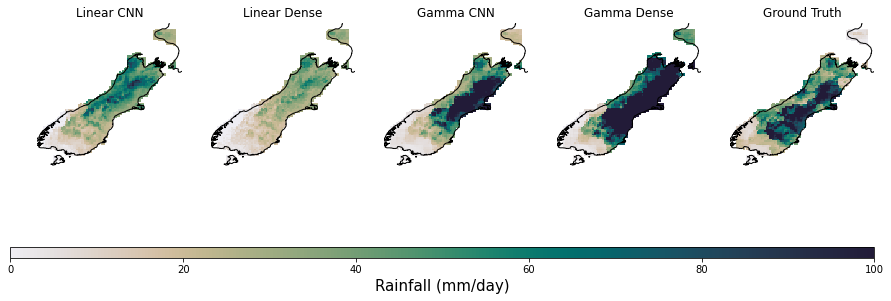

In [ ]:
date = "2018-02-20"
fig, ax = plt.subplots(1,5, figsize = (15, 5), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude = 171.77)))
ax = ax.ravel()
cbar_dict = dict(shrink =0.8, label = 'Daily Rainfall (mm/day)')
exps = ['Simple_cnn','simple_dense', 'cnn_gamma', 'linear_gamma']
for i in range(4):
    concat_predictions.sel(time =date, experiments =exps[i])['test'].sel(lat = slice(-39, -47),
                                                                            lon = slice(167, 175)).plot(vmin =0, vmax =100,
                                                                            cmap ='cmo.rain', ax = ax[i],
                                                                            add_colorbar =False,transform = ccrs.PlateCarree())                                            

cs = gt.sel(time =date).sel(lat = slice(-39, -47),
                               lon = slice(167, 175)).plot(vmin =0, vmax =100, cmap ='cmo.rain', ax = ax[-1],
                                                                            add_colorbar =False,transform = ccrs.PlateCarree())          
[axes.set_title('') for axes in ax]
[axes.coastlines('10m') for axes in ax]
ax4 = fig.add_axes([0.1, 0.05, 0.8, 0.03])
cbar = fig.colorbar(cs, cax=ax4, orientation ='horizontal')
cbar.set_label('Rainfall (mm/day)', fontsize =15)
ax[0].set_title('Linear CNN')
ax[1].set_title('Linear Dense')
ax[2].set_title('Gamma CNN')
ax[3].set_title('Gamma Dense')
ax[4].set_title('Ground Truth')
# #[axes.add_feature(feature, zorder =5, color ='white') for axes in ax]
# ax[-1].set_title('Observations')
# ax[1].set_title('Non-linear Gamma Dense')
# ax[2].set_title('Linear Dense')
# ax[0].set_title('Non-linear Dense')
# #ax[1].set_title('Non-linear Gamma Dense')
# ax[3].set_title('CNN')
# ax[-2].set_title('CNN Gamma')
def remove_spines(ax):
    ax.set_frame_on(False)
    #fig.tight_layout()
[remove_spines(axes) for axes in ax]
# #fig.savefig('Comparison_of_simple_downsclaing_methods.pdf', dpi =300)
#fig.savefig('Comparison_of_simple_downsclaing_methods.png', dpi =300)